<img src='../IMG/TUD_logo.png' align='right' width='15%'></img>

# Darcy Law


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import numpy as np
import json
from ipywidgets import *
from IPython.display import display,clear_output

material_dict= {
        "Sand":{
            "color":"gold",
            "k":1E-4
        },
        "Gravel":{
            "color":"gray",
            "k":1E-2
        },
        "Clay":{
            "color":"peru",
            "k":1E-6
        }
    }
actions = ["Add Observation", "Reset Observations", "Calculate RMSE"]
q_tracking = []
h_diff_tracking = []

In [ ]:
english = True

with open("/home/grabow/Dropbox/SHK/Jupyter/HydroTeaching/dictionary.json", 'r') as f:
    language = json.load(f)
if english:
    ylabel = language["Druckpotential"] + " (m)"
else:
    ylabel = "Druckpotential" + " (m)"

In [2]:
ylabel = "Druckpotential" + " (m)"

In [3]:
def plot_triangle(x, y, ax, stretch):
    """
    Plot a water triangle
    
    Keyword Arguments:
    x -- x postion of triangle tip (water table)
    y -- y position of triangle tip
    ax -- axes to plot on
    stetch -- height and half the base length of the symmetric triangle
    """
    tgl = [[x, y],[x - stretch, y + stretch],[x + stretch, y + stretch]]
    ax.add_patch(Polygon(tgl))
    ax.hlines(y, x - stretch, x + stretch)
    ax.hlines(y - stretch * 0.5, x - stretch * 0.66, x + stretch * 0.66)
    ax.hlines(y - stretch, x - stretch * 0.33, x + stretch * 0.33)
    

def plot_darcy_column(h1, h2, material):
    """
    Plot a Darcy column
    
    Keyword Arguments:
    h1 -- head inside column, m
    h2 -- head of outlet, m
    material -- material inside column. Defined by material_dict
    
    TODO: Avoid globaliszing variables to speak to observation plot
    """
    
    global q, h1_out, h2_out
    h1_out = h1
    h2_out = h2
    
    # Prepare plot
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.set_aspect("equal")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel(ylabel, fontsize=13)
    
    # Define lenghts in m
    column_height = 15
    column_width = 5
    sediment_height = 5
    distance_gauge_column = gauge_width = 0.9
    overlap_left = 0.5
    arrow_length_max = 2.
    arrow_width_max = .3
    
    # Define verticies
    p1 = (0, column_height)
    p2 = (column_width, column_height)
    p3 = (column_width, gauge_width)
    p4 = (column_width + distance_gauge_column, gauge_width)
    p5 = (column_width + distance_gauge_column, gauge_width + h2)
    p6 = (column_width + distance_gauge_column + gauge_width + overlap_left, gauge_width + h2)
    p7 = (column_width + distance_gauge_column + gauge_width + overlap_left, h2)
    p8 = (column_width + distance_gauge_column + gauge_width, h2)
    p9 = (column_width + distance_gauge_column + gauge_width, 0)
    p10 = (0,0)
    p11 = (column_width,0)
    
    # Plot material
    ax.add_patch(Rectangle((0,0), sediment_height, column_width,
                 color = material_dict[material]["color"]))
    
    # Plot water column
    ax.add_patch(Rectangle((0,sediment_height), column_width, h1 - sediment_height,
                 color = "skyblue", alpha=0.8))
    
    # Plot lengths
    shape = [p2, p3, p4, p5, p6, p7, p8, p9, p10, p1]
    x, y = zip(*shape)
    plt.plot(x, y, c="black")
    
    # add triangle
    stretch = column_width * 0.05
    x_dist = column_width / 2
    plot_triangle(x_dist, h1, ax, stretch)
    
    
    if h1 > h2:
        # Calculate discharge after Darcy
        q = material_dict[material]["k"] * (h1 - h2)
        q_max = material_dict[material]["k"] * column_height
        # Plot arrow for discharge
        arrow_length = arrow_length_max * q / q_max
        arrow_width = arrow_width_max * q / q_max
        plt.arrow(p6[0],
                 h2 + 0.5 * gauge_width, arrow_length, 0,
                 length_includes_head = True,
                 width = arrow_width)
        txt = "Q = " + str(round(q, 6)) + r" $\frac{m^3}{s}$"
        plt.text(p6[0] + arrow_length,p6[1], txt, fontsize=13)
        gauge = [p3, p4, p5, p6, p7, p8, p9, p11]
    else:
        p12 = (column_width+distance_gauge_column,h1)
        p13 = (column_width+distance_gauge_column+gauge_width,h1)
        plt.hlines(p12[1], p12[0],p13[0])
        x_dist = column_width + distance_gauge_column + gauge_width / 2
        plot_triangle(x_dist, h1, ax, stretch)
        gauge = [p3, p4,p12, p13,p9, p11]
    ax.add_patch(Polygon(gauge, color="skyblue", alpha=0.8))
    

In [4]:
interact(plot_darcy_column,
         h1 = widgets.BoundedFloatText(value=11, min=5, max=15, step=1, description='H1', disabled=False),
         h2 = widgets.BoundedFloatText(value=0, min=0, max=15, step=1, description='H2:', disabled=False),
         material = widgets.Dropdown(options=material_dict.keys(),value="Sand", description="Material"))


interactive(children=(BoundedFloatText(value=11.0, description='H1', max=15.0, min=5.0, step=1.0), BoundedFloa…

<function __main__.plot_darcy_column(h1, h2, material)>

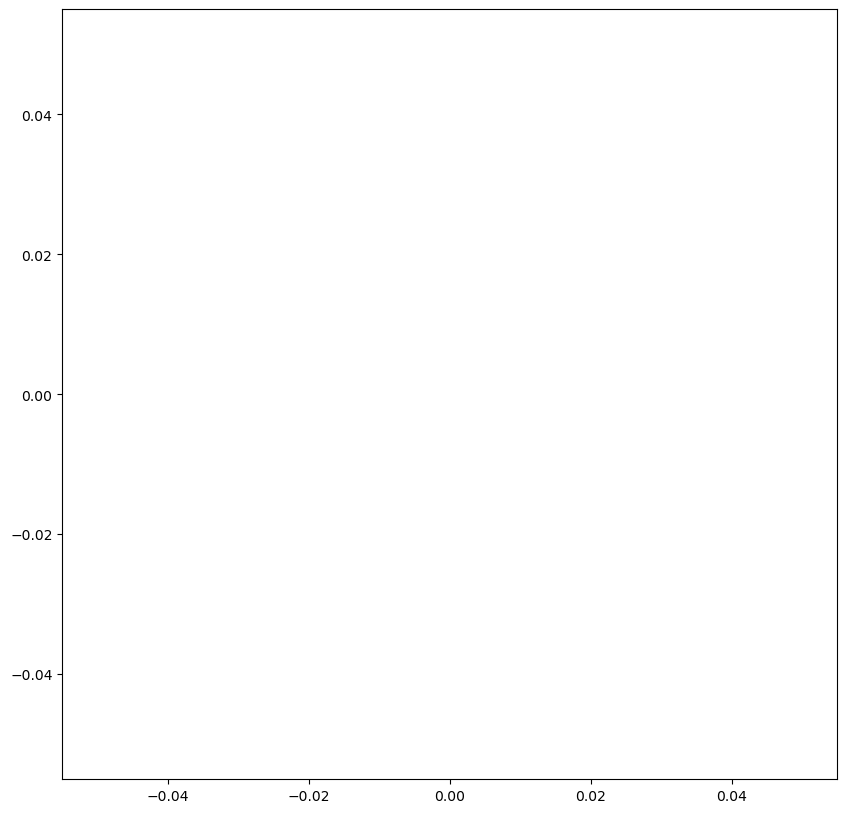

In [5]:
#%matplotlib inline

# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

plt.ioff()
fig2 = plt.figure(figsize=(10,10))
ax2 = plt.subplot(111)
plt.grid()

def plot_observation():
    """
    Plot head difference vs discharge and calucate the regression
    
    Keyword Arguments:
    h1 -- head inside column, m
    h2 -- head of outlet, m
    q -- discharge, m^3/s
    """

    # Prepare plot
    ax2.clear()
    ax2.scatter(h_diff_tracking, q_tracking)
    with output:
        clear_output(wait=True)
        display(ax2.figure)
        
    plt.show()


def add_obsvervation(_):
    global q_tracking, h_diff_tracking
    q_tracking.append(q)
    h_diff_tracking.append(h1_out - h2_out)
    plot_observation()
    
def clear_observation(_):
    global q_tracking, h_diff_tracking
    q_tracking = []
    h_diff_tracking = []
    plot_observation()
    
def calc_res(_):
    pass
    
output = widgets.Output()

button1 = widgets.Button(description='Add Observation')
button2 = widgets.Button(description='Clear Observations')
button3 = widgets.Button(description='Calculate linear regression')

# displaying button and its output together
vbox = widgets.VBox([button1,button2, button3, output])
display(vbox)

button1.on_click(add_obsvervation)
button2.on_click(clear_observation)
button3.on_click(calc_res)
clear_observation(None)

<hr>
&copy; 2022 | Thomas Reimann
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>